In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [2]:
RANDOM_SEED = 42

In [3]:
!pip freeze > requirements.txt

In [4]:
# функции для построения confusion matrix и ROC

def PlotConfusionMatrix(y_test_fold, pred, y_test_0, y_test_1):
    """Функция для построения confusion matrix"""
    cfn_matrix = confusion_matrix(y_test_fold, pred)
    cfn_norm_matrix = np.array(
    [[1.0 / y_test_0, 1.0/y_test_0], [1.0/y_test_1, 1.0/y_test_1]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    fig = plt.figure(figsize=(6,4))
    sns.heatmap(norm_cfn_matrix, cmap='coolwarm_r',
            linewidths=0.5, annot=True)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    print('---Classification Report---')
    print(classification_report(y_test_fold, pred, labels=np.unique(pred)))
    
    
def AUC_ROC(model):
    """Функция для построения ROC-кривой и расчета AUC"""
    # посчитаем fpr, tpr для всех thresholds
    probs = model.predict_proba(x_test_fold)
    pred = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test_fold, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## **1. DATA**

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-scoring'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 3 # в тесте у нас нет значения default, мы его должны предсказать, заполним "3"

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# 2. DATA PREPROCESSING

In [10]:
# обработаем колонку app_date
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [11]:
# посмотрим на разброс дат
start_d = data.app_date.min()
end_d = data.app_date.max()
print(data.app_date.min())
print(data.app_date.max())

2014-01-01 00:00:00
2014-04-30 00:00:00


In [12]:
# создадим признак days
data['days'] = ((data.app_date-start_d).dt.days.astype('int')**2)

In [13]:
# посмотрим на значения признака education
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [14]:
# заполним пустые ячейки наиболее популярным значением "SCH" (* эксперименты с медианой, ср. значением и т.д. показали, что максимизировать AUC удалось только при заполнении ниже)
data['education'] = data['education'].fillna('SCH')

In [15]:
# создадим списки колонок для предобработки
bin_cols = ['sex','car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['home_address', 'work_address','education']
num_cols = ['income','bki_request_cnt','age']
other_num_cols = ['score_bki','region_rating','sna','first_time','decline_app_cnt','days']

## 2.1 Обработка числовых признаков

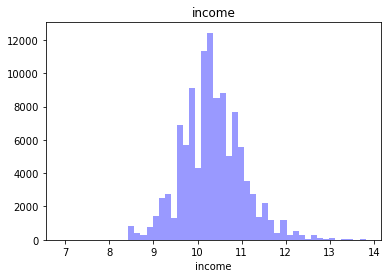

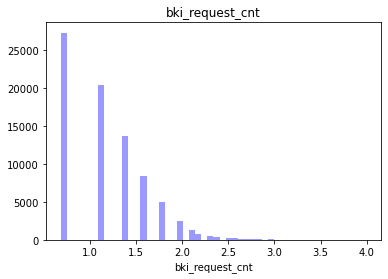

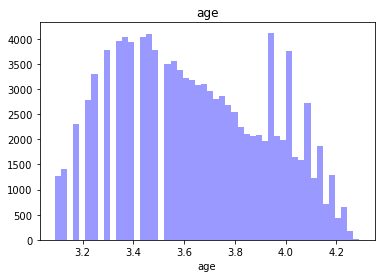

In [16]:
# посмотрим на распределение числовых признаков и логарифмируем их
for i in num_cols:
    data[i] = np.log(data[i]+1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

**Визуально видно, что числовые признаки нужно будет стандартизировать перед построением модели**

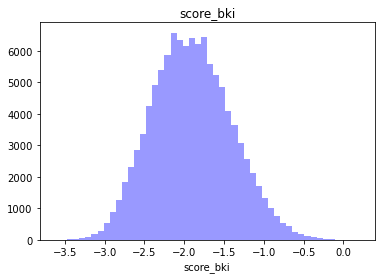

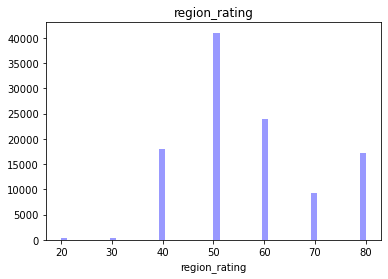

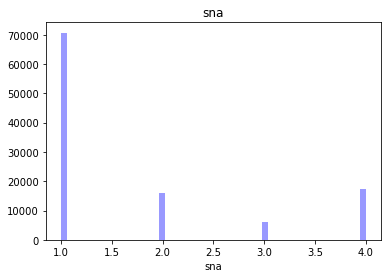

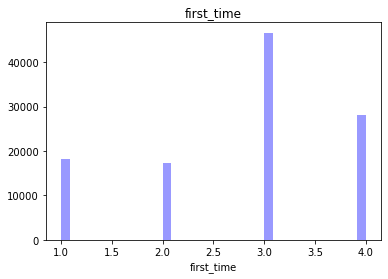

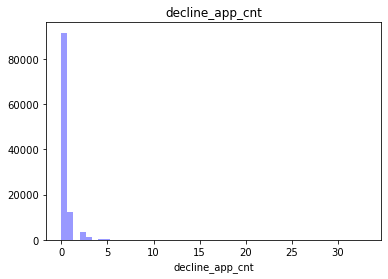

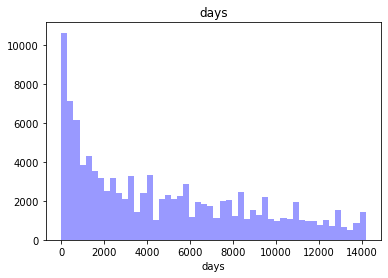

In [17]:
# посмотрим на распределение оставшихся числовых признаков
for i in other_num_cols:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

**Визуально видно, что часть признаков перевести в категориальные в связи с небольшим количеством значений**

In [18]:
# посмотрим на количество значений признака decline_app_cnt
print(data['decline_app_cnt'].nunique())
print(data['decline_app_cnt'].value_counts())

24
0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64


Большинство значений сконцетрировано в промежутке от 1 до 5, попробуем перевести признак в категориальный

In [19]:
# переведем decline_app_cnt в категориальный признак
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: 6 if x>=6 else x)

In [20]:
# изменим списки признаков
bin_cols = ['car','sex', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['home_address', 'work_address','education', 'region_rating','sna','first_time','decline_app_cnt']
num_cols = ['income','bki_request_cnt','age']
other_num_cols = ['score_bki','days']

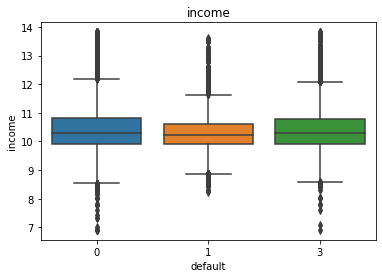

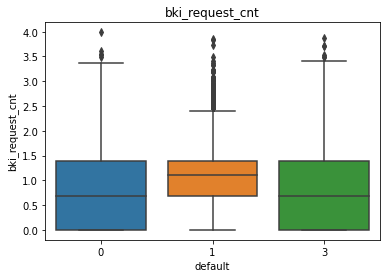

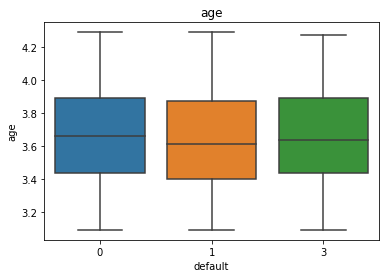

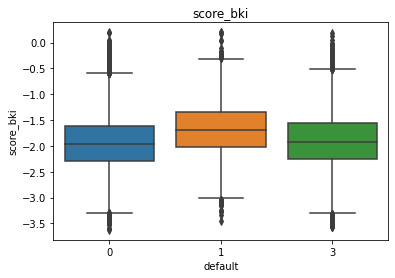

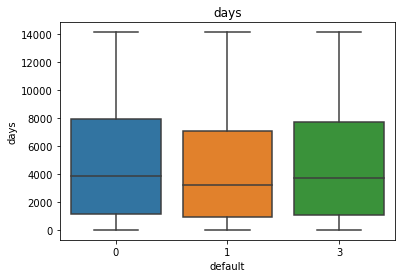

In [21]:
# построим box-plots для числовых признаков
for i in num_cols+other_num_cols:
    plt.figure()    
    sns.boxplot(x="default", y=i, data=data)
    plt.title(i)
    plt.show()

**Визуально видно наличие выбросов, посмотрим на них подробнее и попробуем с ними поработать**

In [22]:
# обработаем выбросы

# посчитаем IQR
Q1 = data[num_cols+other_num_cols].quantile(0.25)
Q3 = data[num_cols+other_num_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

income                0.875440
bki_request_cnt       1.386294
age                   0.457833
score_bki             0.692546
days               6832.000000
dtype: float64


In [23]:
# посчитаем количество возможных выбросов
data[num_cols+other_num_cols][(data[num_cols+other_num_cols] < (Q1 - 1.5 * IQR)) |(data[num_cols+other_num_cols] > (Q3 + 1.5 * IQR))].count()

income             2609
bki_request_cnt      15
age                   0
score_bki           518
days                  0
dtype: int64

In [24]:
# данные в колонках days, score_bki нельзя отнести к выбросам, исходя из природы этих данных, поэтому поработаем с колонкой income

# заполним выбросы в столбце income медианой (эксперименты с заполнением другими значениями показали, что заполнение медианой максимизирует AUC, а у нас соревнование)

low_income = (Q1.income - 1.5 * IQR.income)
high_income = (Q3.income + 1.5 * IQR.income)

income_outliers_low = (data['income'] < (Q1.income - 1.5 * IQR.income))
income_outliers_high = (data['income'] > (Q3.income + 1.5 * IQR.income))

data.loc[income_outliers_low,'income'] = data.income.median()
data.loc[income_outliers_high,'income'] = data.income.median()

In [25]:
# посмотрим выбросы признака bki_request_cnt
print(data['bki_request_cnt'].loc[(data['bki_request_cnt']  < (Q1.bki_request_cnt - 1.5 * IQR.bki_request_cnt))].value_counts())
print(data['bki_request_cnt'].loc[(data['bki_request_cnt']  > (Q3.bki_request_cnt + 1.5 * IQR.bki_request_cnt))].value_counts())

Series([], Name: bki_request_cnt, dtype: int64)
3.496508    4
3.713572    2
3.526361    2
3.828641    1
3.850148    1
3.871201    1
3.610918    1
3.555348    1
3.988984    1
3.737670    1
Name: bki_request_cnt, dtype: int64


In [26]:
# заполним выбросы в столбце bki_request_cnt средним значением
bki_request_cnt_outliers_high = (data['bki_request_cnt'] > (Q3.bki_request_cnt + 1.5 * IQR.bki_request_cnt))
data.loc[bki_request_cnt_outliers_high,'bki_request_cnt'] = data.bki_request_cnt.mean()

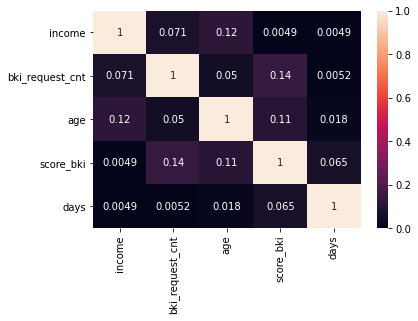

In [27]:
# построим heat-map числовых (непрерывных) переменных
sns.heatmap(data[num_cols+other_num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

**Наблюдается наибольшая корреляция между признаками score_bki, bki_request_cnt, income и age, но, в целом, признаки не сильно скоррелированы**

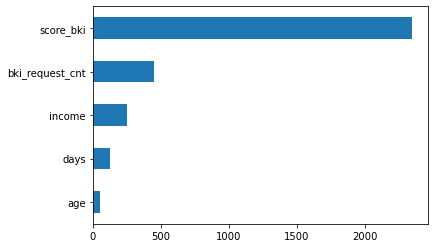

In [28]:
# посмотрим на значимость числовых признаков для модели
data_temp = data[data['sample']==1]
imp_num = Series(f_classif(data_temp[num_cols+other_num_cols], data_temp['default'])[0], index = num_cols+other_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Самыми важными признаками являются score_bki и bki_request_cnt**

## 2.2 Обработка бинарных и категориальных признаков

In [29]:
# закодируем бинарные признаки с помощью LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days
0,74835,2014-03-22,GRD,1,3.401197,1,1,0,0,-2.271884,...,50,1,2,10.819798,1,4,0,0,3,6400
1,17527,2014-01-24,SCH,0,3.688879,0,0,5,0,-1.504999,...,50,1,2,10.308986,4,3,0,0,3,529
2,75683,2014-03-23,UGR,1,3.931826,1,1,0,0,-1.691339,...,50,1,2,10.308986,1,3,1,0,3,6561
3,26883,2014-02-03,SCH,1,4.043051,0,0,0,0,-2.374182,...,40,1,2,9.741027,1,3,0,0,3,1089
4,28862,2014-02-04,GRD,0,3.663562,0,0,0,0,-2.487502,...,80,2,3,11.695255,1,3,0,0,3,1156


In [30]:
# закодируем признак education 
edu_list = data['education'].value_counts().index.to_list()
ordinal_encoder = OrdinalEncoder(categories=[edu_list,])
data[['education',]] = ordinal_encoder.fit_transform(data[['education',]])

In [31]:
#создадим dummy-переменные для категориальных признаков
data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
#X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [32]:
# обновим список категориальных колонок
data.columns

Index(['client_id', 'app_date', 'sex', 'age', 'car', 'car_type', 'good_work',
       'score_bki', 'bki_request_cnt', 'income', 'foreign_passport', 'sample',
       'default', 'days', 'home_address_1', 'home_address_2', 'home_address_3',
       'work_address_1', 'work_address_2', 'work_address_3', 'education_0.0',
       'education_1.0', 'education_2.0', 'education_3.0', 'education_4.0',
       'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1',
       'first_time_2', 'first_time_3', 'first_time_4', 'decline_app_cnt_0',
       'decline_app_cnt_1', 'decline_app_cnt_2', 'decline_app_cnt_3',
       'decline_app_cnt_4', 'decline_app_cnt_5', 'decline_app_cnt_6'],
      dtype='object')

In [33]:
cat_cols = data.columns[14:].to_list()
cat_cols

['home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'education_0.0',
 'education_1.0',
 'education_2.0',
 'education_3.0',
 'education_4.0',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'decline_app_cnt_0',
 'decline_app_cnt_1',
 'decline_app_cnt_2',
 'decline_app_cnt_3',
 'decline_app_cnt_4',
 'decline_app_cnt_5',
 'decline_app_cnt_6']

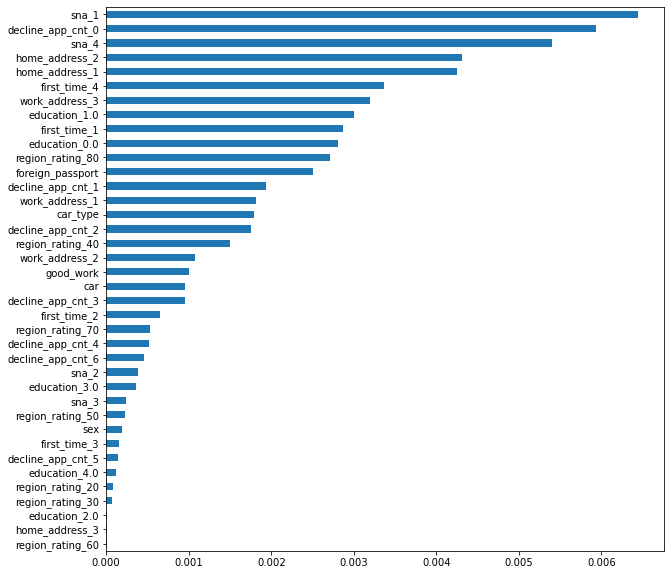

In [34]:
# посмотрим на важность бинарных и категориальных признаков для модели

data_temp = data[data['sample']==1]

mp_cat = Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                    discrete_features =True), index = bin_cols + cat_cols)
mp_cat.sort_values(inplace = True)
plt.figure(figsize=(10,10))
mp_cat.plot(kind = 'barh')

Очевидно у последних признаков нет корреляции с таргетом, поэтому удалим их при построении модели

In [35]:
# отбрасываем "лишнее"
cols_to_drop = mp_cat.index[0:5].to_list()
print(cols_to_drop)
data_cols = mp_cat.index.to_list()
data_cols = list(set(data_cols) - set(cols_to_drop))
data_cols

['region_rating_60', 'home_address_3', 'education_2.0', 'region_rating_30', 'region_rating_20']


['work_address_3',
 'home_address_2',
 'work_address_1',
 'sex',
 'education_1.0',
 'region_rating_70',
 'decline_app_cnt_3',
 'home_address_1',
 'sna_3',
 'region_rating_80',
 'decline_app_cnt_2',
 'car_type',
 'car',
 'good_work',
 'decline_app_cnt_5',
 'decline_app_cnt_0',
 'first_time_2',
 'education_3.0',
 'sna_1',
 'decline_app_cnt_4',
 'region_rating_50',
 'first_time_4',
 'education_4.0',
 'sna_2',
 'work_address_2',
 'decline_app_cnt_1',
 'decline_app_cnt_6',
 'foreign_passport',
 'education_0.0',
 'first_time_3',
 'region_rating_40',
 'sna_4',
 'first_time_1']

## 2.3. Подготовка к построению модели 

In [36]:
# выделим обратно тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [37]:
train_data.head()

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,...,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,decline_app_cnt_5,decline_app_cnt_6
36349,25905,2014-02-01,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,...,0,0,0,1,0,0,0,0,0,0
36350,63161,2014-03-12,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,...,0,0,0,1,0,0,0,0,0,0
36351,25887,2014-02-01,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,...,0,0,1,0,0,1,0,0,0,0
36352,16222,2014-01-23,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,...,0,1,0,1,0,0,0,0,0,0
36353,101655,2014-04-18,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,...,0,0,1,1,0,0,0,0,0,0


In [38]:
test_data.head()

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,...,first_time_2,first_time_3,first_time_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,decline_app_cnt_5,decline_app_cnt_6
0,74835,2014-03-22,1,3.401197,1,1,0,-2.271884,1.386294,10.819798,...,0,0,1,1,0,0,0,0,0,0
1,17527,2014-01-24,0,3.688879,0,0,0,-1.504999,1.098612,10.308986,...,0,1,0,0,0,0,0,0,1,0
2,75683,2014-03-23,1,3.931826,1,1,0,-1.691339,0.693147,10.308986,...,0,1,0,1,0,0,0,0,0,0
3,26883,2014-02-03,1,4.043051,0,0,0,-2.374182,0.693147,9.741027,...,0,1,0,1,0,0,0,0,0,0
4,28862,2014-02-04,0,3.663562,0,0,0,-2.487502,0.000000,11.695255,...,0,1,0,1,0,0,0,0,0,0


In [39]:
# стандартизируем числовые признаки
st = StandardScaler()
st.fit(train_data[num_cols+other_num_cols].values)
X_num = st.transform(train_data[num_cols+other_num_cols].values)

In [40]:
# выделим признаки и таргет
X = np.hstack([X_num, train_data[data_cols].values])
Y = train_data['default'].values

In [41]:
# сформируем тестовую выборку
X_num_test = st.transform(test_data[num_cols+other_num_cols].values)
X_test_test = np.hstack([X_num_test, test_data[data_cols].values])

In [42]:
# посмотрим на распределение целевой переменной
train_data['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

### Данные несбалансированы, количество положительных исходов гораздо меньше отрицательных, необходимо будет учесть это при построении модели, иначе модель будет предсказывать только отсутствие дефолта, что повлечет убытки для банка

# 3. Построение модели 

In [43]:
# для начала построим модель логистической регресии с параметрами по умолчанию, не учитывая несбалансированность классов

# разделим данные на обучающую и тестовую выборки
X_train, x_test_fold, y_train, y_test_fold = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

# посчитаем кол-во 0 и 1 на тесте
y_test_0 = np.sum(y_test_fold==0)
y_test_1 = np.sum(y_test_fold==1)

model = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(x_test_fold)
probs = probs[:,1]
pred = model.predict(x_test_fold)

print('Confusion matrix: \n', confusion_matrix(y_test_fold,pred))
print('AUC: %.8f' % roc_auc_score(y_test_fold,probs))

# построим Confusion matrix
PlotConfusionMatrix(y_test_fold,pred,y_test_0,y_test_1)

# построим ROC-кривую и посчитаем AUC
AUC_ROC(model)

NameError: name 'y_test' is not defined

Из анализа confusion matrix видим, что при относительно высоком значении AUC (0.75), модель правильно определяет вероятность дефолта только в незначительном числе случаев, что дает очень много ложно-отрицательных результатов, что повлечет убытки, если данные клиенты допустят дефолт в будущем

In [ ]:
# попробуем оптимизировать параметры модели, запускаем GridSearch

logreg = LogisticRegression(class_weight='balanced', max_iter=500)
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

In [ ]:
# строим модель, используя оптимальные параметры и Kfold-разбиение на тестовую и обучающую выборки (т.к. при сабмите предсказаний baseline
# модели была довольно существенная разница в AUC)

model = LogisticRegression(C=0.05, random_state=RANDOM_SEED, class_weight='balanced', max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED) 
pred_test_full =0
cv_score =[]
i=1
   
for train_index, test_index in skf.split(X, Y): 
    print('{} of KFold {}'.format(i,skf.n_splits))
    x_train_fold, x_test_fold = X[train_index], X[test_index] 
    y_train_fold, y_test_fold = Y[train_index], Y[test_index] 
    model.fit(x_train_fold, y_train_fold)
    probs = model.predict_proba(x_test_fold)
    probs = probs[:,1]
    score = roc_auc_score(y_test_fold,probs)
    print('ROC AUC score:',score)
    pred_test = model.predict_proba(X_test_test)[:,1]
    pred_test_full += pred_test
    cv_score.append(score)
    i+=1 
pred = model.predict(x_test_fold)
y_test_0 = np.sum(y_test_fold==0)
y_test_1 = np.sum(y_test_fold==1)
print('AUC',cv_score,'\nMean AUC',np.mean(cv_score))    
#print('Confusion matrix: \n', confusion_matrix(y_test,pred_test_full))
#print('AUC: %.8f' % roc_auc_score(y_test,pred_test_full))

# построим Confusion matrix
PlotConfusionMatrix(y_test_fold,pred,y_test_0,y_test_1)

# построим ROC-кривую и посчитаем AUC
AUC_ROC(model)

**Выводы:** величина AUC изменилась незначительно, при этом мы добились существенного снижения числа "дефолтных" клиентов, которых модель ошибочно отнесла к классу "надежных", Recall для таких клиентов, т.е. показатель того, насколько много дефолтных клиентов среди всех дефолтных клиентов выбрала модель увеличился с 0.02 до 0.65. F1-score для дефолтного класса удалось увеличить с 0.04 до 0.33.
В зависимости от того какой threshold выберет банк, итоговая модель скоринга может быть как крайне консервативной, так и допускать большее количество "рискованных" кредитов.

# 4. SUBMISSION

In [ ]:
test_data.sample(10)

In [ ]:
sample_submission

In [ ]:
y_pred_prob = pred_test_full/10
submit = pd.DataFrame(test_data.client_id)
submit['default'] = y_pred_prob
submit

In [ ]:
submit.to_csv('submission.csv', index=False)